In [22]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def f(x):
    return 3*x**2 - 4*x + 5

In [24]:
f(3.0)

20.0

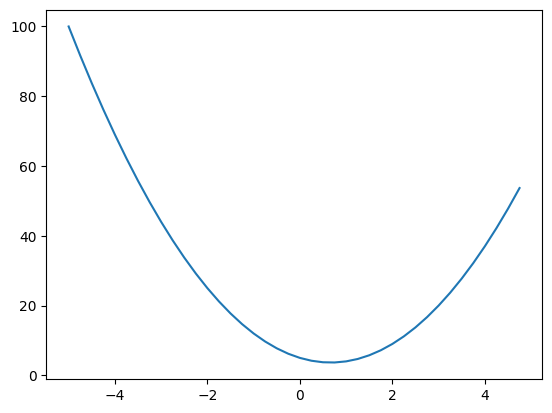

In [25]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [26]:
h = 0.00000001
x = 2/3
(f(x+h) - f(x))/h

0.0

In [27]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [28]:
h = 0.000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
print("d1: ", d1)
print("d2: ", d2)
print("slope: ", (d2 - d1)/h)

d1:  4.0
d2:  4.000000999999999
slope:  0.9999999992515995


In [29]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if (isinstance(other, Value)) else Value(other) 
        
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out 
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if (isinstance(other, Value)) else Value(other) 

        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad        
        out._backward = _backward
        return out 
    
    def __pow__(self, other):        
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other -1 )) * out.grad
        out._backward = _backward     
        return out
        
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**(-1)
    
    def __neg__(self):
        return self * (-1)
        
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self - other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            

In [30]:
a = Value(2.0)
b = 3.0
b - a

Value(data=-1.0)

In [31]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


In [32]:
# input values
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b1 = Value(6.8813735870195432, label='b1')

# forward prop
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b1; n.label='n'

e = (2*n).exp()
o = (e + 1) / e - 1

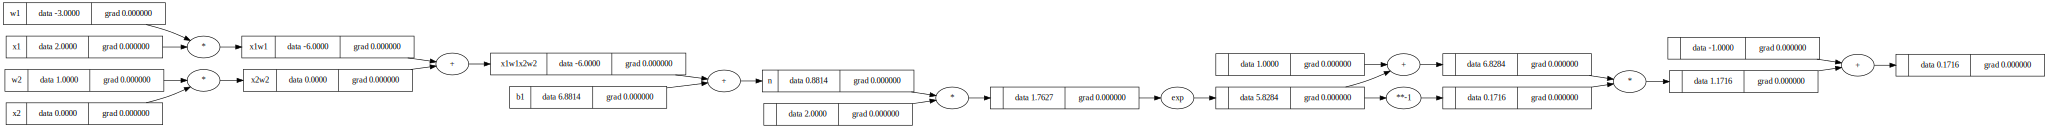

In [33]:
draw_dot(o)

In [34]:
o.backward()

## Pytorch 

In [35]:
# import torch
# 
# x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
# x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
# w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
# w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
# b1 = torch.Tensor([6.8813735870195432]).double()   ; b1.requires_grad = True
# n = x1*w1 + x2*w2 + b1
# o = torch.tanh(n)
# 
# print(o.data.item())
# o.backward()
# 
# print("---")
# print('x2', x2.grad.item())
# print('w2', w2.grad.item())
# print('x1', x1.grad.item())
# print('w1', w1.grad.item())

In [48]:
class Neuron:
    
    def __init__(self, nin):
        """
        :param nin: number of inputs for neuron
        """
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum((xi*wi for xi, wi in zip(self.w, x)), self.b)              
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    
    def __init__(self, nin, nout):
        """
        :param nin: number of inputs 
        :param nout: number of outputs
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    
    def __init__(self, nin, nouts):
        """
        :param nin: number of inputs 
        :param nouts: number of outputs
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [49]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.47463230013753693)

In [50]:
n.parameters()

[Value(data=-0.21486553946261),
 Value(data=-0.8205767006813172),
 Value(data=0.3928892564916602),
 Value(data=0.9999265688090582),
 Value(data=-0.7708807271810683),
 Value(data=-0.5531209648867024),
 Value(data=0.11352376138703857),
 Value(data=-0.2459991726667603),
 Value(data=0.8927939239896356),
 Value(data=-0.6353514044518775),
 Value(data=-0.20580993389482516),
 Value(data=-0.0476353640041598),
 Value(data=0.27353935463325607),
 Value(data=0.8851869982112683),
 Value(data=0.33250232625550935),
 Value(data=0.7417782408241602),
 Value(data=0.6648247282437005),
 Value(data=-0.09183500501957287),
 Value(data=-0.1203796157510395),
 Value(data=-0.9134474874230414),
 Value(data=0.24551223767966213),
 Value(data=0.31978298738078204),
 Value(data=0.4959790242833382),
 Value(data=0.3967559912989844),
 Value(data=0.6290000907249478),
 Value(data=0.5283323482520488),
 Value(data=-0.7386776723956836),
 Value(data=0.1296407309660026),
 Value(data=-0.9412375541676803),
 Value(data=0.56398374075

In [51]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [54]:
y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.8946814361851715),
 Value(data=-0.9347574730969392),
 Value(data=-0.815853024498202),
 Value(data=0.837789379598809)]

In [53]:
for k in range(20):
    # forward pass
    y_pred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])
    
    # zero grad
    for p in n.parameters():
        p.grad = 0.0
    
    # backward pass
    loss.backward()
    
    # update 
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)



0 2.727045608122124
1 1.7717577302361054
2 1.182737905939907
3 0.8002776137541283
4 0.5717465413178678
5 0.4362449557868959
6 0.3478816891991139
7 0.28607898447685776
8 0.24110149436140704
9 0.2072522325401297
10 0.1810415389017288
11 0.16025118763107732
12 0.14342052112322518
13 0.12955643827452057
14 0.11796420295258564
15 0.10814538548799994
16 0.09973432352312567
17 0.0924573962342919
18 0.08610622039893182
19 0.08051958078129592
